In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [2]:
df = pd.read_csv('./../p_lungcancer_all_add2.csv')
df2 = df.copy()

In [3]:
df.Stage.value_counts()

Stage
Stage 4    7151
Stage 1    3338
Stage 3    2765
Stage 2    1743
Stage 0       3
Name: count, dtype: int64

In [4]:
df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2

In [5]:
df.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,Death,Survival_period,EGFR_0,EGFR_1,EGFR_99,Drink_1,Drink_2,Drink_3,Drink_99,BMI
0,72,Stage 1,0.0,0.0,1,1,0,1,0,0,...,0,157,False,False,True,False,False,False,True,33.822654
1,66,Stage 4,2.0,4.5,1,0,0,0,0,1,...,0,567,False,False,True,False,False,False,True,18.984376
2,75,Stage 4,0.0,0.0,1,1,0,1,0,0,...,0,253,False,False,True,False,False,True,False,25.596524
3,77,Stage 4,2.0,8.0,1,0,1,0,0,1,...,0,266,False,True,False,False,True,False,False,31.486033
4,85,Stage 1,2.5,0.0,1,0,0,0,0,0,...,0,470,False,False,True,False,True,False,False,14.922211


In [6]:
#T0는 종양이 존재하지 않음을 의미. 즉, 종양이 없다는 정보이기 때문에 다른 T 값들과 합산하면 의미가 왜곡될 우려 있음.
#TX는 종양의 크기를 정확하게 알 수 없다는 의미, 사실상 정보가 없다고 볼 수 있음. 
# 따라서 TX를 다른 T 값들과 합산하면 제대로 된 의미를 갖지 못함.
# T0와 TX는 제외하고 T1~T4 값만 합산
df['T_sum'] = df[['T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4']].sum(axis=1)

In [7]:
# 각 T 항목에 대해 사이즈 곱하기
df['T_sized_sum'] = (df['T1'] * 2 +
                        df['T1a'] * 0.5 +
                        df['T1b'] * 1.5 +
                        df['T1c'] * 2.5 +
                        df['T2'] * 4 +
                        df['T2a'] * 3.5 +
                        df['T2b'] * 4.5 +
                        df['T3'] * 6 +
                        df['T4'] * 8.5)

In [8]:
# 각 N 항목에 대해 원하는 사이즈 곱하기 (2, 4.5, 8)
df['N_sized_sum'] = (df['N1'] * 2 +
                        df['N2'] * 4.5 +
                        df['N3'] * 8)

In [9]:
# N 항목 합산하기
df['N_sum'] = df['N1'] + df['N2'] + df['N3']

In [10]:
# M 항목 합산하기
df['M_sum'] = df['M1a'] + df['M1b'] + df['M1c']

In [11]:
# 각 T 항목에 대해 원하는 가중치 곱하기
df['T_weighted_sum'] = (df['T1'] * 1 +
                        df['T1a'] * 1 +
                        df['T1b'] * 1 +
                        df['T1c'] * 1 +
                        df['T2'] * 1 +
                        df['T2a'] * 1 +
                        df['T2b'] * 1 +
                        df['T3'] * 2 +
                        df['T4'] * 3)

In [12]:
# 각 N 항목에 대해 원하는 가중치 곱하기 (2, 2.5,3)
df['N_weighted_sum'] = (df['N1'] * 2 +
                        df['N2'] * 2.5 +
                        df['N3'] * 3)

In [13]:
# 각 M 항목에 대해 원하는 가중치 곱하기 (3,4,5)
df['M_weighted_sum'] = (df['M1a'] * 3 +
                        df['M1b'] * 4 +
                        df['M1c'] * 5)

In [14]:
df.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,Drink_99,BMI,T_sum,T_sized_sum,N_sized_sum,N_sum,M_sum,T_weighted_sum,N_weighted_sum,M_weighted_sum
0,72,Stage 1,0.0,0.0,1,1,0,1,0,0,...,True,33.822654,0,0.0,0.0,0,0,0,0.0,0
1,66,Stage 4,2.0,4.5,1,0,0,0,0,1,...,True,18.984376,1,2.0,4.5,1,1,1,2.5,4
2,75,Stage 4,0.0,0.0,1,1,0,1,0,0,...,False,25.596524,0,0.0,0.0,0,1,0,0.0,4
3,77,Stage 4,2.0,8.0,1,0,1,0,0,1,...,False,31.486033,1,2.0,10.0,2,1,1,5.0,3
4,85,Stage 1,2.5,0.0,1,0,0,0,0,0,...,False,14.922211,1,2.5,0.0,0,0,1,0.0,0


In [15]:
from sklearn.preprocessing import OrdinalEncoder

# 'stage' 컬럼에 대해 순서 지정 (1기 → 4기)
stage_order = [['Stage 0','Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']]

# OrdinalEncoder 객체 생성 및 적용
encoder = OrdinalEncoder(categories=stage_order)
df['Stage'] = encoder.fit_transform(df[['Stage']])

In [16]:
df.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,Drink_99,BMI,T_sum,T_sized_sum,N_sized_sum,N_sum,M_sum,T_weighted_sum,N_weighted_sum,M_weighted_sum
0,72,1.0,0.0,0.0,1,1,0,1,0,0,...,True,33.822654,0,0.0,0.0,0,0,0,0.0,0
1,66,4.0,2.0,4.5,1,0,0,0,0,1,...,True,18.984376,1,2.0,4.5,1,1,1,2.5,4
2,75,4.0,0.0,0.0,1,1,0,1,0,0,...,False,25.596524,0,0.0,0.0,0,1,0,0.0,4
3,77,4.0,2.0,8.0,1,0,1,0,0,1,...,False,31.486033,1,2.0,10.0,2,1,1,5.0,3
4,85,1.0,2.5,0.0,1,0,0,0,0,0,...,False,14.922211,1,2.5,0.0,0,0,1,0.0,0


In [17]:
#Smoke에 원핫 인코딩하기
df = pd.get_dummies(data = df, columns=['Smoke'], drop_first=True)

In [18]:
#범주형을 제외한 컬럼에 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Tumor_Size', 'lymph_node_meta_size','Height','Weight','FEV1_FVC_P',
        'DLCO_VA_P','AGE','Survival_period','BMI', 
        'T_sum','N_sum','M_sum','T_weighted_sum','N_weighted_sum','M_weighted_sum','T_sized_sum','N_sized_sum']] = scaler.fit_transform(df[['Tumor_Size', 'lymph_node_meta_size','Height','Weight',
                           'FEV1_FVC_P','DLCO_VA_P','AGE','Survival_period','BMI',
                          'T_sum','N_sum','M_sum',
                           'T_weighted_sum','N_weighted_sum','M_weighted_sum','T_sized_sum','N_sized_sum']])

In [18]:
#df 컬럼 확인
df.columns

Index(['AGE', 'Stage', 'Tumor_Size', 'lymph_node_meta_size', 'Adenocarcinoma',
       'Large_cell_carcinoma', 'Squamous_cell_carcinoma', 'TX', 'T0', 'T1',
       'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N0', 'N1', 'N2',
       'N3', 'M0', 'M1a', 'M1b', 'M1c', 'Height', 'Weight', 'FEV1_FVC_P',
       'DLCO_VA_P', 'Operation', 'Chemotherapy', 'Radiation_Therapy', 'Death',
       'Survival_period', 'EGFR_0', 'EGFR_1', 'EGFR_99', 'Drink_1', 'Drink_2',
       'Drink_3', 'Drink_99', 'BMI', 'T_sum', 'T_sized_sum', 'N_sized_sum',
       'N_sum', 'M_sum', 'T_weighted_sum', 'N_weighted_sum', 'M_weighted_sum',
       'Smoke_1', 'Smoke_2'],
      dtype='object')

In [20]:
#Train data set 분리
df_train = df.iloc[0:10000]

In [21]:
#Test data set 분리
df_test = df.iloc[10000:15000]

In [22]:
# Test data set에 대한 reset index 실행
df_test.reset_index(drop=True, inplace=True)

In [23]:
df_test.head()

,AGE,Stage,Tumor_Size,lymph_node_meta_size,Adenocarcinoma,Large_cell_carcinoma,Squamous_cell_carcinoma,TX,T0,T1,...,T_sum,T_sized_sum,N_sized_sum,N_sum,M_sum,T_weighted_sum,N_weighted_sum,M_weighted_sum,Smoke_1,Smoke_2
0,-1.902632,4.0,0.736174,-0.829312,1,0,0,0,0,0,...,0.558768,0.736174,-0.817569,-1.022336,1.047668,0.058894,-0.994531,1.072939,True,False
1,-0.186232,2.0,-0.302270,-0.118879,1,0,0,0,0,0,...,0.558768,-0.302270,-0.128025,0.852134,-0.954501,0.058894,0.513629,-0.919212,False,False
2,-1.216072,4.0,-0.925337,-0.118879,1,1,1,1,0,0,...,-1.789653,-0.925337,-0.128025,0.852134,1.047668,-1.244074,0.513629,1.570977,False,False
3,-2.177256,4.0,-0.925337,-0.118879,0,0,0,1,0,0,...,-1.789653,-0.925337,-0.128025,0.852134,1.047668,-1.244074,0.513629,0.574902,True,False
4,-0.529512,3.0,-0.717648,2.012420,0,0,1,0,0,0,...,0.558768,-0.717648,1.940607,0.852134,-0.954501,0.058894,1.267710,-0.919212,True,False


In [24]:
df_train2 = df_train.copy()

In [25]:
df_train.Death.value_counts()

Death
0    7897
1    2103
Name: count, dtype: int64

In [26]:
df_test.Death.value_counts()

Death
0    3089
1    1911
Name: count, dtype: int64

In [27]:
#Train Classifier data set - X
train_C_x = df_train.drop(columns=['Death','Drink_1','Drink_2','Drink_3','Drink_99','EGFR_99',
                                   'T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N1', 'N2', 'N3', 'M1a', 'M1b', 'M1c' ], axis=1)

In [28]:
#Train Classifier data set - Target
train_C_y = df_train.Death.values

In [29]:
train_C_x.shape

(10000, 32)

In [37]:
#Train Classifier data set - X
X = df.drop(columns=['Death','Drink_1','Drink_2','Drink_3','Drink_99','EGFR_99',
                                   'T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N1', 'N2', 'N3', 'M1a', 'M1b', 'M1c' ], axis=1)

In [20]:
#Train Classifier data set - Target
Y = df.Death.values

In [30]:
#Test Classifier data set - X
test_C_x = df_test.drop(columns=['Death','Drink_1','Drink_2','Drink_3','Drink_99','EGFR_99',
                                 'T1', 'T1a', 'T1b', 'T1c', 'T2', 'T2a', 'T2b', 'T3', 'T4', 'N1', 'N2', 'N3', 'M1a', 'M1b', 'M1c' ], axis=1)

In [31]:
##Test Classifier data set - target
test_C_y = df_test.Death.values

<Axes: ylabel='Frequency'>

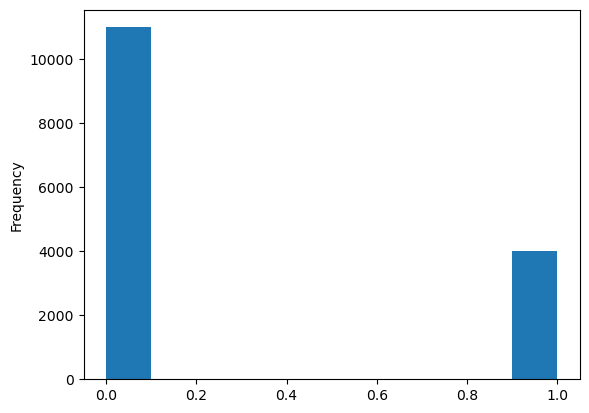

In [32]:
df.Death.plot(kind='hist')

<Axes: ylabel='Frequency'>

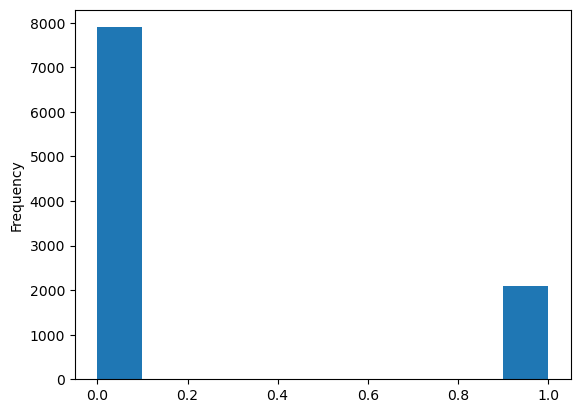

In [33]:
df_train.Death.plot(kind='hist')

<Axes: ylabel='Frequency'>

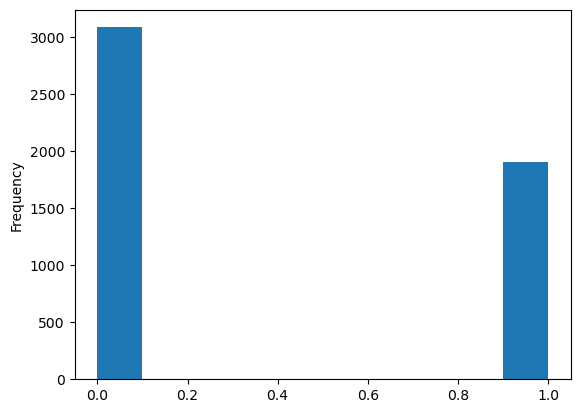

In [34]:
df_test.Death.plot(kind='hist')

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = rf_model.predict(X_test)
print("정확도:", accuracy_score(y_test, y_pred))
print("혼동 행렬:\n", confusion_matrix(y_test, y_pred))
print("분류 보고서:\n", classification_report(y_test, y_pred))

정확도: 0.7333333333333333
혼동 행렬:
 [[2193   13]
 [ 787    7]]
분류 보고서:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85      2206
           1       0.35      0.01      0.02       794

    accuracy                           0.73      3000
   macro avg       0.54      0.50      0.43      3000
weighted avg       0.63      0.73      0.63      3000



In [24]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. 특징(X)과 목표(y) 설정
X = df[['T_sized_sum', 'N_sized_sum', 'M_sum', 'T_weighted_sum', 'N_weighted_sum', 'M_weighted_sum']]
Y = df['Death']

# 2. 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 3. SMOTE 적용 (훈련 데이터에만!)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 4. 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# 5. 예측 및 평가
y_pred = rf_model.predict(X_test)

print("정확도:", accuracy_score(y_test, y_pred))
print("혼동 행렬:\n", confusion_matrix(y_test, y_pred))
print("분류 보고서:\n", classification_report(y_test, y_pred))

정확도: 0.5603333333333333
혼동 행렬:
 [[1290  916]
 [ 403  391]]
분류 보고서:
               precision    recall  f1-score   support

           0       0.76      0.58      0.66      2206
           1       0.30      0.49      0.37       794

    accuracy                           0.56      3000
   macro avg       0.53      0.54      0.52      3000
weighted avg       0.64      0.56      0.59      3000



In [25]:
# 모든 컬럼 사용
X = df.drop(columns=['Death'])  # 목표 변수 'Death' 제외
Y = df['Death']

# 이후 코드 동일:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)
print("정확도:", accuracy_score(y_test, y_pred))
print("혼동 행렬:\n", confusion_matrix(y_test, y_pred))
print("분류 보고서:\n", classification_report(y_test, y_pred))

정확도: 0.7296666666666667
혼동 행렬:
 [[2169   37]
 [ 774   20]]
분류 보고서:
               precision    recall  f1-score   support

           0       0.74      0.98      0.84      2206
           1       0.35      0.03      0.05       794

    accuracy                           0.73      3000
   macro avg       0.54      0.50      0.44      3000
weighted avg       0.63      0.73      0.63      3000



In [27]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
# 모델 정의

#model = RandomForestClassifier(n_estimators=100)
model = LogisticRegression(max_iter=1000)

# 교차 검증을 통해 최적의 특성 개수 선택
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X, Y)

# 최적의 특성 개수와 선택된 특성 출력
print(f"최적의 특성 개수: {rfecv.n_features_}")
print(f"선택된 특성: {X.columns[rfecv.support_]}")

NameError: name 'LogisticRegression' is not defined

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# train_test_split을 이용해 훈련/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 모델 정의
#model = RandomForestClassifier(n_estimators=100,random_state=42  )
model = LogisticRegression(max_iter=1000)

# RFECV로 훈련 데이터에 대해 특성 선택
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train, y_train)

# 선택된 특성 출력
print(f"최적의 특성 개수: {rfecv.n_features_}")
print(f"선택된 특성: {X_train.columns[rfecv.support_]}")

# 최적의 특성으로 훈련된 모델 평가
X_train_selected = X_train.iloc[:, rfecv.support_]  # 선택된 특성만 사용
X_test_selected = X_test.iloc[:, rfecv.support_]  # 테스트 데이터에 대해서도 동일하게 적용

# 모델 훈련
model.fit(X_train_selected, y_train)

# 테스트 데이터 평가
y_pred = model.predict(X_test_selected)
accuracy = model.score(X_test_selected, y_test)
print(f"테스트 데이터 정확도: {accuracy}")

c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

최적의 특성 개수: 1
선택된 특성: Index(['TX'], dtype='object')
테스트 데이터 정확도: 0.7353333333333333


In [43]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
import lightgbm as lgb

[LightGBM] [Info] Number of positive: 2835, number of negative: 7665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.270000 -> initscore=-0.994623
[LightGBM] [Info] Start training from score -0.994623
[LightGBM] [Info] Number of positive: 2835, number of negative: 7665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 31
[LightGBM] [Info] [bin

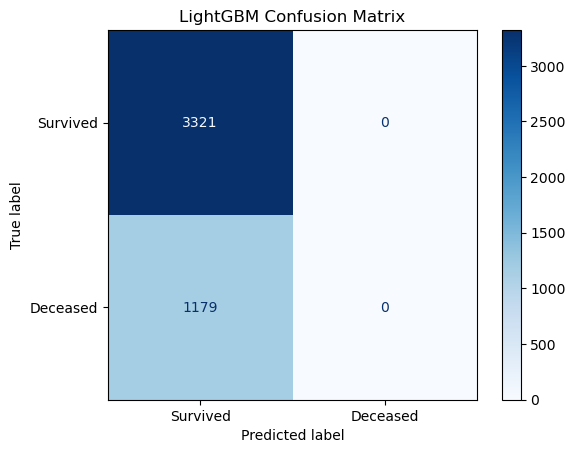

LightGBM 모델 예측값: [0 0 0 0 0 0 0 0 0 0]


ValueError: The number of FixedLocator locations (32), usually from a call to set_ticks, does not match the number of labels (1).

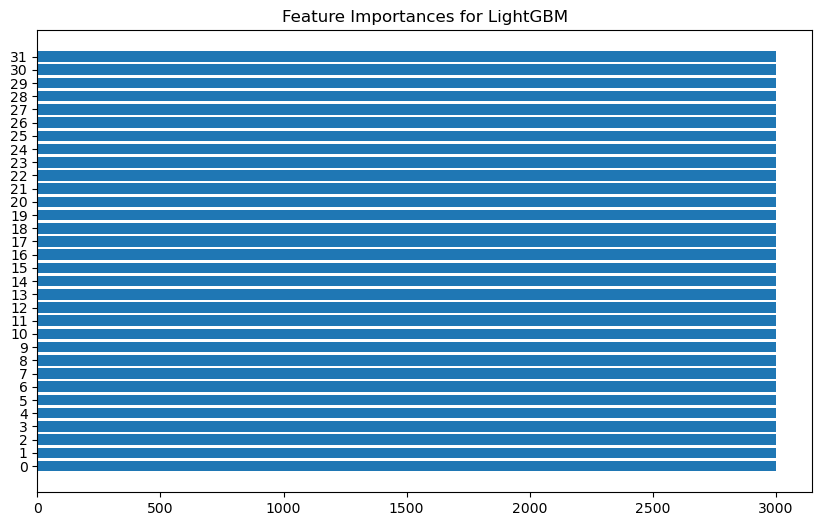

In [44]:
models = {
    #'Logistic Regression': LogisticRegression(max_iter=1000),
    #'Random Forest': RandomForestClassifier(n_estimators=100,random_state=42 ),
    #'SVM': SVC(kernel='linear', C=1, random_state=42)
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42),
    #'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0)
}

# X, y 데이터 준비 (예시 데이터, 여러분의 데이터셋을 사용해주세요)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# RFECV 파이프라인 적용
results = {}

for model_name, model in models.items():
    # RFECV 설정
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(3), scoring='accuracy', n_jobs=-1)
    
    # 파이프라인 설정
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 정규화 추가
        ('rfecv', rfecv),
        ('model', model)
    ])
    
    # 모델 학습
    pipeline.fit(X_train, y_train)
    
    # 예측 및 성능 평가
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 정확도 평가
    accuracy = pipeline.score(X_test, y_test)
    print(f"{model_name} 모델 정확도: {accuracy}")
    
    # 선택된 특성 출력
    print(f"{model_name} 모델 - 최적의 특성 개수: {rfecv.n_features_}")
    print(f"{model_name} 모델 - 선택된 특성: {X_train.columns[rfecv.support_]}")
    
    # 혼동 행렬 출력
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Survived', 'Deceased'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


    # 예측된 값 출력 (선택 사항)
    print(f"{model_name} 모델 예측값:", y_pred[:10])  # 예측된 값의 일부 출력
    print("="*50)  # 모델 구분을 위한 구분선
    

    # 결과 저장
    results[model_name] = accuracy

    # 특성 중요도 시각화
    if hasattr(model, 'feature_importances_'):  # 모델이 feature_importances_ 속성을 가질 때만
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]  # 중요도 순으로 내림차순 정렬
        feature_names = X.columns

        # 특성 이름에 대해 중요도를 그래프로 시각화
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances for {model_name}")
        plt.barh(range(X.shape[1]), importances[indices], align="center")
        plt.yticks(range(X.shape[1]), X.columns[indices])
        plt.xlabel("Relative Importance")
        plt.show()


# 결과 출력
for model_name, accuracy in results.items():
    print(f"{model_name}: Accuracy = {accuracy}")

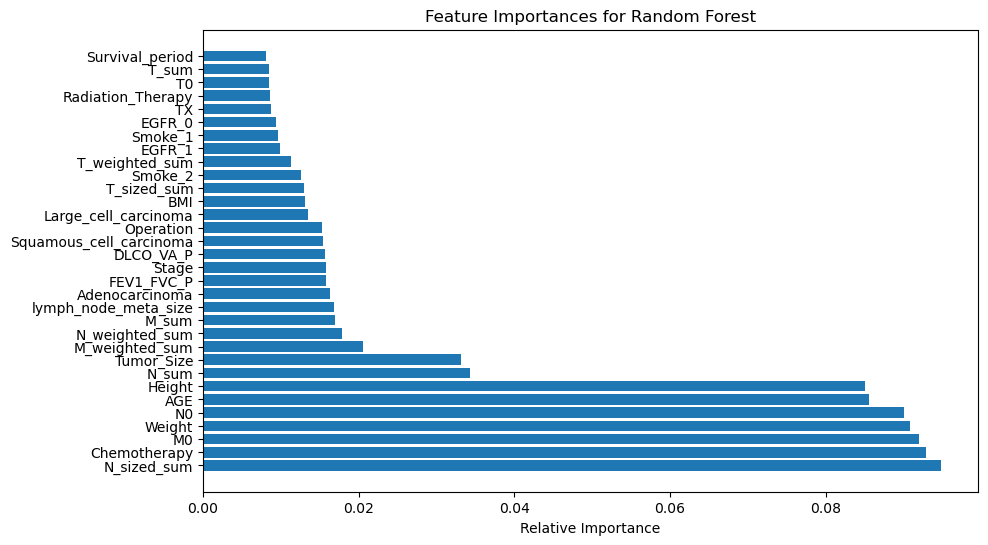

In [39]:
# 특성 중요도 시각화
 # 모델이 feature_importances_ 속성을 가질 때만
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 중요도 순으로 내림차순 정렬
feature_names = X.columns

    # 특성 이름에 대해 중요도를 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.title(f"Feature Importances for {model_name}")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Relative Importance")
plt.show()
